#                                           Chicago Crime Analysis

In [50]:
import numpy as np 
import re
import pandas as pd 
import seaborn as sns
from datetime import datetime
import time
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from geopy.geocoders import Nominatim
from sklearn.cluster import AgglomerativeClustering as AC

Downloading crimes and weather datasets from the below links:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
http://mrcc.isws.illinois.edu/CLIMATE/Station/Daily/StnDyBTD2.jsp
Crimes datasets contains data from 2001 to present date.
Weather dataset contains 2008 to present date.

Reading both the data into dataframe "crimes" and "weather"

In [51]:
crimes1 = pd.read_csv('Crimes_-_2008_2010.csv',error_bad_lines=False)
crimes2 = pd.read_csv('Crimes_-_2011_2014.csv',error_bad_lines=False)
crimes3 = pd.read_csv('Crimes_-_2015_2017.csv',error_bad_lines=False)
weather = pd.read_csv('weather_2008_2017.csv',error_bad_lines=False)
crimes = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)


Removing duplicates by using drop duplicates.

In [52]:
crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)

In [53]:
# columns present in dataset crimes
crimes.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [54]:
# Columns information including datatype and dataset details
crimes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3258000 entries, 0 to 799649
Data columns (total 22 columns):
ID                      int64
Case Number             object
Date                    object
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
dtypes: bool(2), float64(7), int64(3), object(10)
memory usage: 528.2+ MB


In [55]:
# Multiple tuples contains Community Area code as 0.0 where the location is near O'hare airport.
#  Below shows the rows with 0 community Area code.
crimes.iloc[np.where(crimes['Community Area']==0)]

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
3718,6473220,HP550036,09/02/2008 09:55:00 PM,046XX W 31ST ST OVERPASS,1350,CRIMINAL TRESPASS,TO STATE SUP LAND,OTHER RAILROAD PROP / TRAIN DEPOT,True,False,...,22.0,0.0,26,NaN,NaN,2008,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4415,6577481,HP650190,10/26/2008 08:30:00 PM,051XX S RUTHERFORD AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,...,23.0,0.0,06,NaN,NaN,2008,08/17/2015 03:03:40 PM,NaN,NaN,NaN
8767,7199882,HR609885,04/21/2008 12:01:00 AM,052XX N OTTO AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,COMMERCIAL / BUSINESS OFFICE,False,False,...,41.0,0.0,06,NaN,NaN,2008,08/17/2015 03:03:40 PM,NaN,NaN,NaN
11928,8389450,HT622044,04/15/2008 03:00:00 PM,081XX W CATHERINE AVE,0890,THEFT,FROM BUILDING,RESIDENCE,False,True,...,NaN,0.0,06,NaN,NaN,2008,08/17/2015 03:03:40 PM,NaN,NaN,NaN
105144,6126316,HP219883,03/11/2008 01:30:00 PM,052XX N OTTO AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,False,...,41.0,0.0,26,1111110.0,1933291.0,2008,02/10/2018 03:50:01 PM,41.973534,-87.866809,"(41.973533721, -87.866808789)"
210810,7181736,HR592792,10/16/2009 09:45:00 AM,0000X S LAKEFRONT DR,0820,THEFT,$500 AND UNDER,STREET,False,False,...,42.0,0.0,06,1179432.0,1900290.0,2009,02/10/2018 03:50:01 PM,41.881682,-87.616586,"(41.881682194, -87.616586389)"
280230,7393398,HS196045,03/03/2010 12:00:00 PM,050XX N CUMBERLAND AVE,1152,DECEPTIVE PRACTICE,ILLEGAL USE CASH CARD,BANK,False,False,...,41.0,0.0,11,1119317.0,1932343.0,2010,02/10/2018 03:50:01 PM,41.970806,-87.836649,"(41.970805689, -87.83664902)"
353010,7509629,HS305302,05/12/2010 12:00:00 PM,050XX N CUMBERLAND AVE,1110,DECEPTIVE PRACTICE,BOGUS CHECK,CREDIT UNION,False,False,...,41.0,0.0,11,1119317.0,1932237.0,2010,02/10/2018 03:50:01 PM,41.970515,-87.836651,"(41.970514812, -87.83665128)"
547368,7852373,HS665536,12/01/2010 09:00:00 AM,051XX S RUTHERFORD AVE,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,RESIDENCE,False,False,...,23.0,0.0,11,1132253.0,1869684.0,2010,02/10/2018 03:50:01 PM,41.798645,-87.790539,"(41.798644975, -87.790538547)"
581671,6051131,HP148076,01/27/2008 05:30:00 PM,052XX N OTTO AVE,2820,OTHER OFFENSE,TELEPHONE THREAT,PARKING LOT/GARAGE(NON.RESID.),False,False,...,41.0,0.0,26,1111110.0,1933291.0,2008,02/28/2018 03:56:25 PM,41.973534,-87.866809,"(41.973533721, -87.866808789)"


In [56]:
# check for values
#update community area from 0 to 76 which is community area code of O'hare 
crimes.iloc[np.where(crimes['Community Area']==0)[0],13]=76

In [57]:
# Creating list of Area name with Community Area code.
areas = {
"1": "Rogers Park Chicago",
"2": "West Ridge Chicago",
"3": "Uptown Chicago",
"4": "Lincoln Square Chicago",
"5": "North Center Chicago",
"6": "Lakeview Chicago",
"7": "Lincoln Park Chicago",
"8": "Near North Side Chicago",
"9": "Edison Park Chicago",
"10": "Norwood Park Chicago",
"11": "Jefferson Park Chicago",
"12": "Forest Glen Chicago",
"13": "North Park Chicago",
"14": "Albany Park Chicago",
"15": "Portage Park Chicago",
"16": "Irving Park Chicago",
"17": "Dunning Chicago",
"18": "Montclare Chicago",
"19": "Belmont Cragin Chicago",
"20": "Hermosa Chicago",
"21": "Avondale Chicago",
"22": "Logan Square Chicago",
"23": "Humboldt Park Chicago",
"24": "West Town Chicago",
"25": "Austin Chicago",
"26": "West Garfield Park Chicago",
"27": "East Garfield Park Chicago",
"28": "Near West Side Chicago",
"29": "North Lawndale Chicago",
"30": "South Lawndale Chicago",
"31": "Lower West Side Chicago",
"32": "Loop Chicago",
"33": "Near South Side Chicago",
"34": "Armour Square Chicago",
"35": "Douglas Chicago",
"36": "Oakland Chicago",
"37": "Fuller Park Chicago",
"38": "Grand Boulevard Chicago",
"39": "Kenwood Chicago",
"40": "Washington Park Chicago",
"41": "Hyde Park Chicago",
"42": "Woodlawn Chicago",
"43": "South Shore Chicago",
"44": "Chatham Chicago",
"45": "Avalon Park Chicago",
"46": "South Chicago",
"47": "Burnside Chicago",
"48": "Calumet Heights Chicago",
"49": "Roseland Chicago",
"50": "Pullman Chicago",
"51": "South Deering Chicago",
"52": "East Side Chicago",
"53": "West Pullman Chicago",
"54": "Riverdale Chicago",
"55": "Hegewisch Chicago",
"56": "Garfield Ridge Chicago",
"57": "Archer Heights Chicago",
"58": "Brighton Park Chicago",
"59": "McKinley Park Chicago",
"60": "Bridgepor Chicagot",
"61": "New City Chicago",
"62": "West Elsdon Chicago",
"63": "Gage Park Chicago",
"64": "Clearing Chicago",
"65": "West Lawn Chicago",
"66": "Chicago Lawn Chicago",
"67": "West Englewood Chicago",
"68": "Englewood Chicago",
"69": "Greater Grand Crossing Chicago",
"70": "Ashburn Chicago",
"71": "Auburn Gresham Chicago",
"72": "Beverly Chicago",
"73": "Washington Heights Chicago",
"74": "Mount Greenwood Chicago",
"75": "Morgan Park Chicago",
"76": "O'Hare Chicago",
"77": "Edgewater Chicago"
}

In [58]:
# converting Community area code to correct datatype and map it with areas list to generate new column 'Area Name' w.r.t
# community area code.

crimes['Community Area'] = crimes['Community Area'].astype(float)
crimes['Community Area'].fillna(0, inplace=True)
crimes['Community Area new'] = crimes['Community Area'].astype(int)
crimes['Community Area'] = crimes['Community Area new'].astype(str)
crimes.iloc[np.where(crimes['Community Area']=='0')[0],13]='76'
crimes['Area Name'] = crimes['Community Area'].map(areas)

In [59]:
# Represents columns having missing values
crimes.columns[crimes.isnull().any()].tolist()
dfEmpty=crimes.isnull().sum()
# number of duplicate rows in each column
print(dfEmpty)

ID                          0
Case Number                 4
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     3384
Arrest                      0
Domestic                    0
Beat                        0
District                   41
Ward                       54
Community Area              0
FBI Code                    0
X Coordinate            26951
Y Coordinate            26951
Year                        0
Updated On                  0
Latitude                26951
Longitude               26951
Location                26951
Community Area new          0
Area Name                   0
dtype: int64


In [60]:
#Representing Null or Nan values present in any column of crime dataset.
null_data = crimes[crimes.isnull().any(axis=1)]
#null_data

Here we try to apply a method where we can pull Latitude and Longitude data by using Area name .By importing geopy library in python we can able to pull Lat and Long data.Only limitation with this is we can pull only 2500 request each day and we have in total 26K missing tuples present.

In [12]:
geolocator = Nominatim() 
lat = crimes[crimes['Latitude'].isnull()]

In [13]:
"""
geolocator = Nominatim() 
lat = crimes[crimes['Latitude'].isnull()]
i = 1
try:
    while i < len(lat):
        print(i)
        lat = crimes[crimes['Latitude'].isnull()]    
        for location, idx in zip(lat['Area Name'][i:i+1000], lat['Area Name'][i:i+1000].index):
            geoloc = geolocator.geocode(location,exactly_one=True, timeout=60) 
            try:
                crimes.loc[idx, "Latitude"] = geoloc.latitude
                #print(d["NLatitude"])
                crimes.loc[idx, "Longitude"] = geoloc.longitude
                #print(d["NLongitude"],geoloc.latitude)
            except:
                pass
    i = i+1000
except IndexError:
    "L"
"""

'\ngeolocator = Nominatim() \nlat = crimes[crimes[\'Latitude\'].isnull()]\ni = 1\ntry:\n    while i < len(lat):\n        print(i)\n        lat = crimes[crimes[\'Latitude\'].isnull()]    \n        for location, idx in zip(lat[\'Area Name\'][i:i+1000], lat[\'Area Name\'][i:i+1000].index):\n            geoloc = geolocator.geocode(location,exactly_one=True, timeout=60) \n            try:\n                crimes.loc[idx, "Latitude"] = geoloc.latitude\n                #print(d["NLatitude"])\n                crimes.loc[idx, "Longitude"] = geoloc.longitude\n                #print(d["NLongitude"],geoloc.latitude)\n            except:\n                pass\n    i = i+1000\nexcept IndexError:\n    "L"\n'

In [61]:
# Crimes types in the data

crimes['Primary Type'].unique()

array(['HOMICIDE', 'SEX OFFENSE', 'CRIM SEXUAL ASSAULT',
       'DECEPTIVE PRACTICE', 'OFFENSE INVOLVING CHILDREN', 'THEFT',
       'ROBBERY', 'MOTOR VEHICLE THEFT', 'CRIMINAL DAMAGE', 'NARCOTICS',
       'OTHER OFFENSE', 'BURGLARY', 'BATTERY', 'PROSTITUTION', 'ASSAULT',
       'CRIMINAL TRESPASS', 'PUBLIC PEACE VIOLATION', 'WEAPONS VIOLATION',
       'KIDNAPPING', 'GAMBLING', 'LIQUOR LAW VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'OBSCENITY', 'ARSON',
       'STALKING', 'INTIMIDATION', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING',
       'CONCEALED CARRY LICENSE VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL'], dtype=object)

In [62]:
# Here we are categorizing the data in generic category like SEX ASSAULT, NARCOTICS, NONVIOLENT, THEFT, OTHER, VIOLENT, CRIMINAL DAMAGE, MURDER and ARSON

crimes.loc[crimes['Primary Type'].isin(["CRIM SEXUAL ASSAULT","PROSTITUTION", "SEX OFFENSE","ASSAULT"]), 'PTYPE2'] = "SEX ASSAULT"
crimes.loc[crimes['Primary Type'].isin(["NARCOTICS","OTHER","NARCOTIC VIOLATION","OTHER NARCOTIC VIOLATION","DECEPTIVE PRACTICE"]), 'PTYPE2'] = "NARCOTICS"
crimes.loc[crimes['Primary Type'].isin(["GAMBLING",
      "INTERFERE WITH PUBLIC OFFICER",
      "INTERFERENCE WITH PUBLIC OFFICER",
      "INTIMIDATION",
      "LIQUOR LAW VIOLATION",
      "OBSCENITY",
      "NON-CRIMINAL",
      "PUBLIC PEACE VIOLATION",
      "PUBLIC INDECENCY",
      "STALKING","CONCEALED CARRY LICENSE VIOLATION",
      "NON-CRIMINAL (SUBJECT SPECIFIED)","NON - CRIMINAL"]), 'PTYPE2'] = "NONVIOLENT"
crimes.loc[crimes['Primary Type'].isin(["MOTOR VEHICLE THEFT","THEFT","BURGLARY","ROBBERY"]), 'PTYPE2'] = "THEFT"
crimes.loc[crimes['Primary Type'].isin(["OTHER OFFENSE", "OFFENSE INVOLVING CHILDREN"]), 'PTYPE2'] = "OTHER"
crimes.loc[crimes['Primary Type'].isin(["KIDNAPPING", "WEAPONS VIOLATION", "OFFENSE INVOLVING CHILDREN","HUMAN TRAFFICKING"]), 'PTYPE2'] = "VIOLENT"
crimes.loc[crimes['Primary Type'].isin(["CRIMINAL DAMAGE","CRIMINAL TRESPASS"]), 'PTYPE2'] = "CRIMINAL DAMAGE"
crimes.loc[crimes['Primary Type'].isin(["BATTERY","HOMICIDE"]), 'PTYPE2'] = "MURDER"
crimes.loc[crimes['Primary Type'].isin(["ARSON"]), 'PTYPE2'] = "ARSON"
#crimes


In [63]:
# Pulling distinct date from the datasets as shown below there are only 1.2 million ut of 3.3 million of data.
crimes['Date'].nunique()

1266146

In [64]:
# Size of dataset after making allthe exclusions
crimes.shape

(3258000, 25)

In [65]:
# Formatting Date column in weather dataset
weather['Date'].head()
weather['NewDate']= pd.to_datetime(weather['Date'],errors='coerce',format = '%d-%m-%Y')

In [66]:
#weather['Date'] and stiping Date column into day, month and year

def cleanDate_W(d):
    return datetime.strptime(str(d), '%Y-%m-%d')

weather['NewDate'] = weather['NewDate'].dt.date.apply(cleanDate_W)
weather['NewDate']= pd.to_datetime(weather['NewDate'],errors='coerce')
weather['Day']= weather['NewDate'].dt.day
weather['Month']= weather['NewDate'].dt.month
weather['Year']= weather['NewDate'].dt.year


In [67]:
# convert dates to pandas datetime format

crimes['Date'] = pd.to_datetime(crimes['Date'], format='%m/%d/%Y %H:%M:%S %p')

# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes.Date)



In [68]:
crimes["jdate"] = crimes['Date'].dt.date

In [69]:
#Weather dataset columns and datatypes
weather.dtypes

Date               object
MEAN              float64
NewDate    datetime64[ns]
Day                 int64
Month               int64
Year                int64
dtype: object

In [70]:
# Final crime dataset
crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Community Area new,Area Name,PTYPE2,jdate
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-22 11:24:00,4756,HP587530,2008-09-22 11:24:00,047XX W GLADYS AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1897935.0,2008,08/17/2015 03:03:40 PM,41.875943,-87.743748,"(41.875942734, -87.743748059)",25,Austin Chicago,MURDER,2008-09-22
2008-09-22 11:37:00,4757,HP587531,2008-09-22 11:37:00,022XX S KIRKLAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,...,1888660.0,2008,08/17/2015 03:03:40 PM,41.850436,-87.733386,"(41.850436084, -87.733385899)",29,North Lawndale Chicago,MURDER,2008-09-22
2008-09-23 09:57:00,4758,HP572693,2008-09-23 09:57:00,027XX W POPE JOHN PAUL II DR,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,True,True,...,1876028.0,2008,08/17/2015 03:03:40 PM,41.815555,-87.693543,"(41.815555438, -87.693542513)",58,Brighton Park Chicago,MURDER,2008-09-23
2008-09-23 01:40:00,4759,HP588309,2008-09-23 01:40:00,056XX W 64TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,ALLEY,False,False,...,1861562.0,2008,08/17/2015 03:03:40 PM,41.776221,-87.762736,"(41.776221083, -87.762736483)",64,Clearing Chicago,MURDER,2008-09-23
2008-09-23 08:25:00,4760,HP589244,2008-09-23 08:25:00,088XX S PRAIRIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,ALLEY,False,False,...,1846297.0,2008,08/17/2015 03:03:40 PM,41.733517,-87.617679,"(41.733517296, -87.617679154)",44,Chatham Chicago,MURDER,2008-09-23


In [71]:
# creating new dictionary weatherd  includes Date and Mean values
weatherd = dict(zip(weather["NewDate"].dt.date, weather["MEAN"]))

In [72]:
#merging the crimes and weatherd dictionary data based on the Date column

crimes["temp"] = crimes["jdate"].apply(lambda x: weatherd[x])
#crimes["temp"].unique()

In [73]:
# Converting temp column data into integer format

crimes["temp"] = crimes["temp"].astype(float)
crimes["temp"] = crimes["temp"].astype(int)

In [74]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'

In [75]:
# converting below columns categorical format for better visualization
crimes['PTYPE2']               = pd.Categorical(crimes['PTYPE2'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

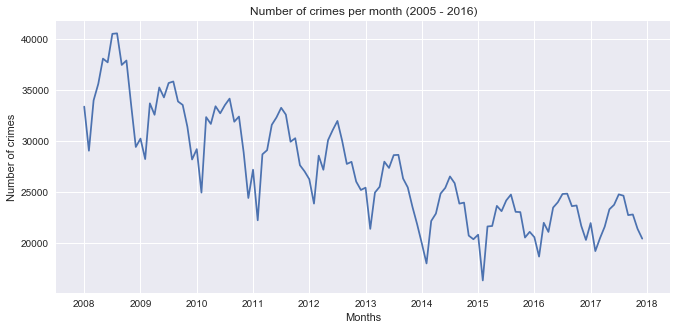

In [76]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot()
plt.title('Number of crimes per month (2005 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

In [77]:
# calculating month,year and day of crime dataset
C_count = crimes[['Date','PTYPE2','temp']]
C_count ['Year'] = C_count['Date'].dt.year
C_count ['Month'] = C_count['Date'].dt.month
C_count ['Day'] = C_count['Date'].dt.day
#C_count

C:\Users\Shringa\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Shringa\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shringa\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

In [78]:
#total number of crimes during the summer

crime_peak = C_count.groupby(['Year','Month'])['PTYPE2'].count().reset_index() #crime peak in the summer
crime_peak[(crime_peak['Month']>5) & (crime_peak['Month']<9)].groupby('Year')['PTYPE2'].sum()

Year
2008    118720
2009    105759
2010    100361
2011     98130
2012     93059
2013     84603
2014     77790
2015     72041
2016     73639
2017     73150
Name: PTYPE2, dtype: int64

In [79]:
#getting the number of crimes, irrespective of crime type, in each month for each year

crime_monthly_count = C_count.groupby([C_count['Date'].dt.year,C_count['Date'].dt.month])['PTYPE2'].count()
crime_monthly_count.index.names=['Year','Month']
crime_monthly_count = crime_monthly_count.reset_index()
#crime_monthly_count

The idea is, for each day, we calculate the sum of crimes of the past year. If this rolling sum is decreasing, then we know for sure that crime rates have been decreasing during that year. On the other hand, if the rolling sum stays the same during a given year, then we can conclude that crime rates stayed the same.

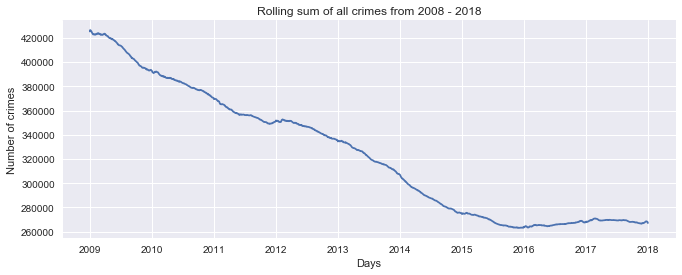

In [80]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2008 - 2018')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

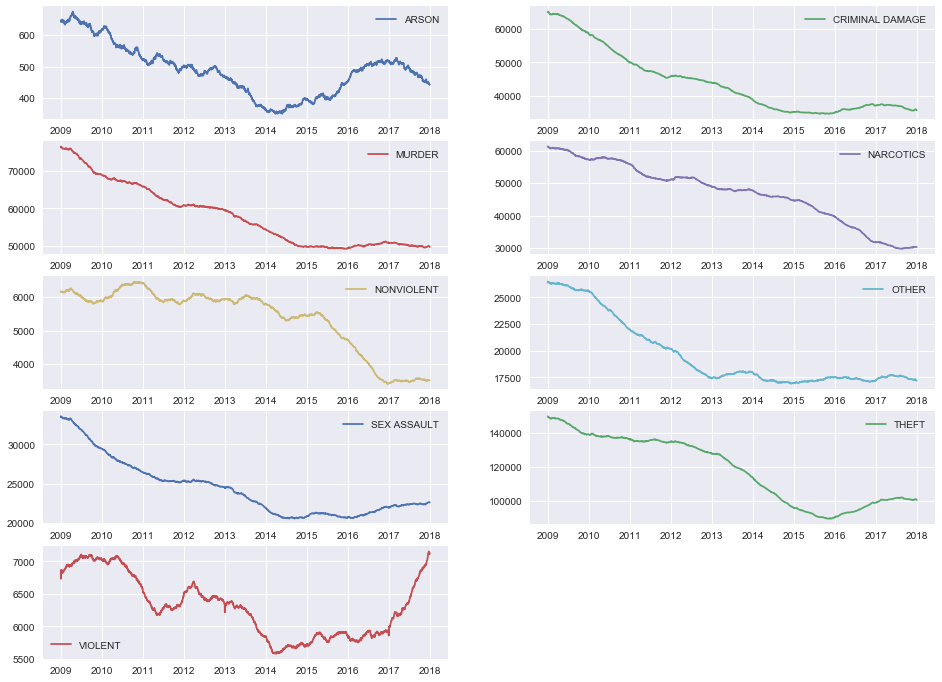

In [81]:
#crime rates by its type
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='PTYPE2', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(16, 12), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

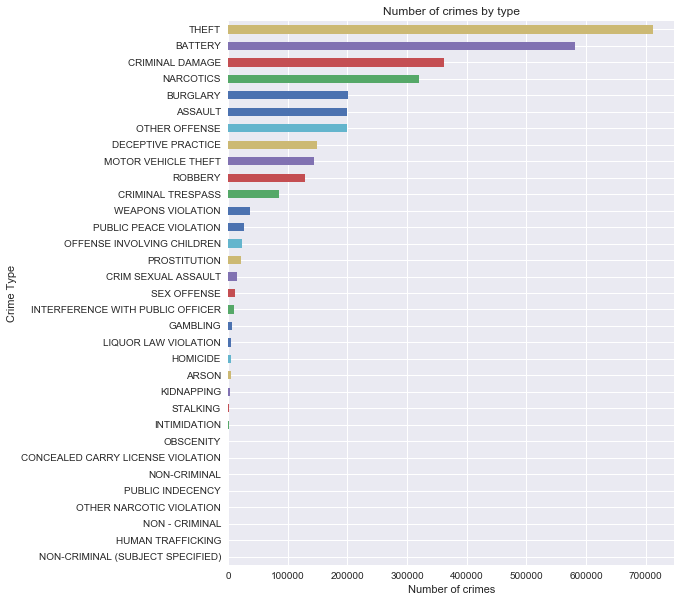

In [82]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

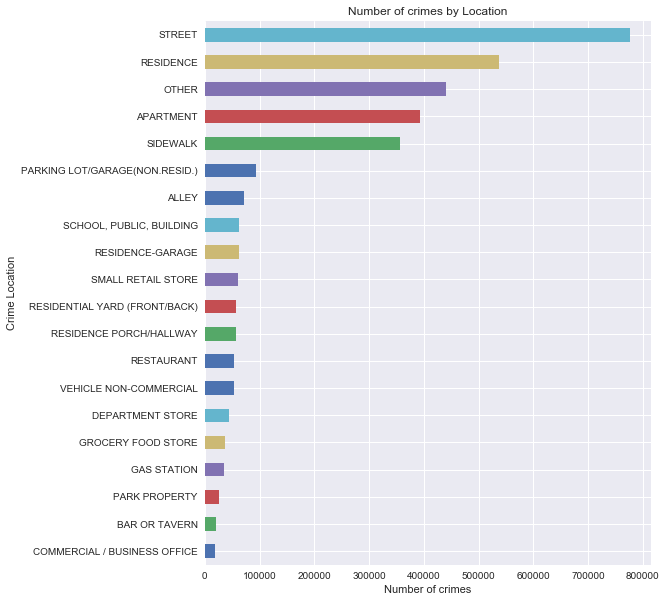

In [83]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

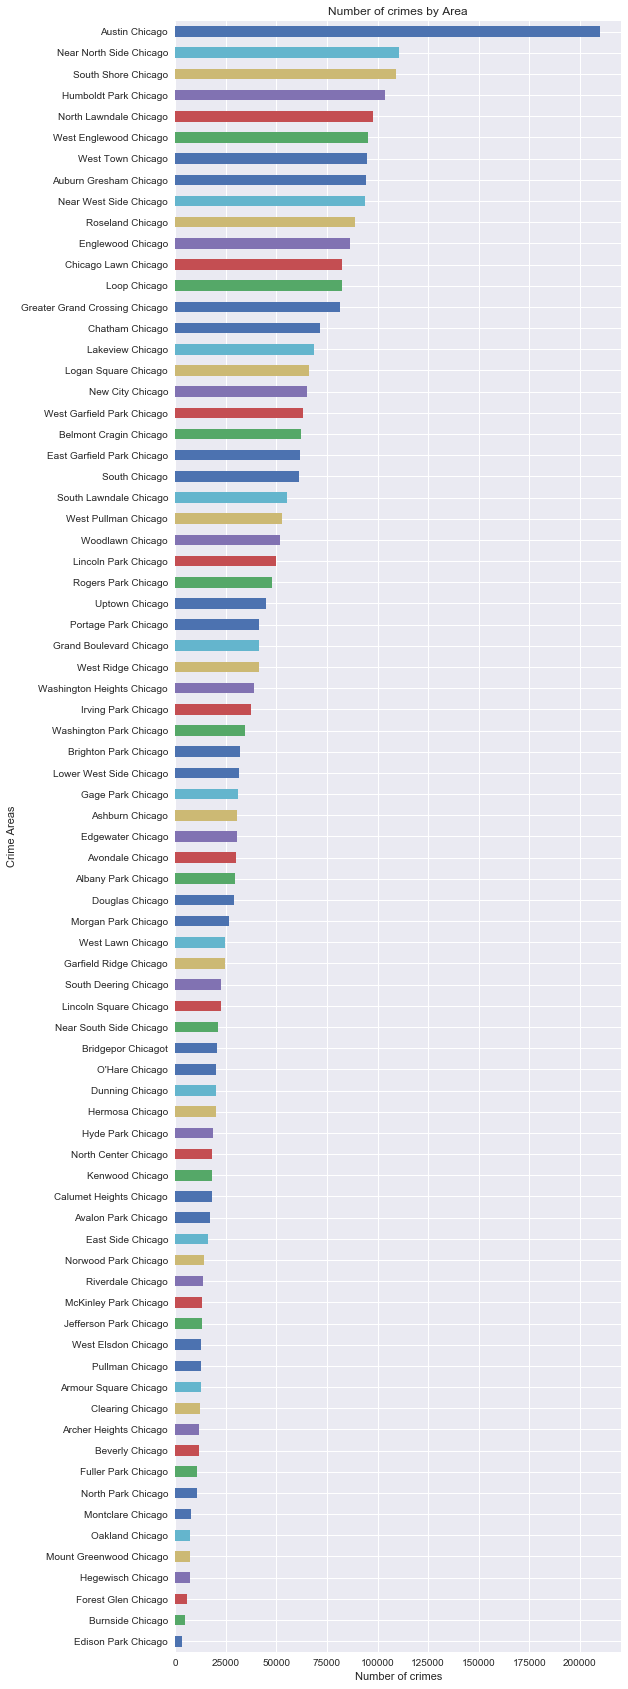

In [84]:
plt.figure(figsize=(8,30))
crimes.groupby([crimes['Area Name']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Area')
plt.ylabel('Crime Areas')
plt.xlabel('Number of crimes')
plt.show()

# Trend Of Temperature and Crimes

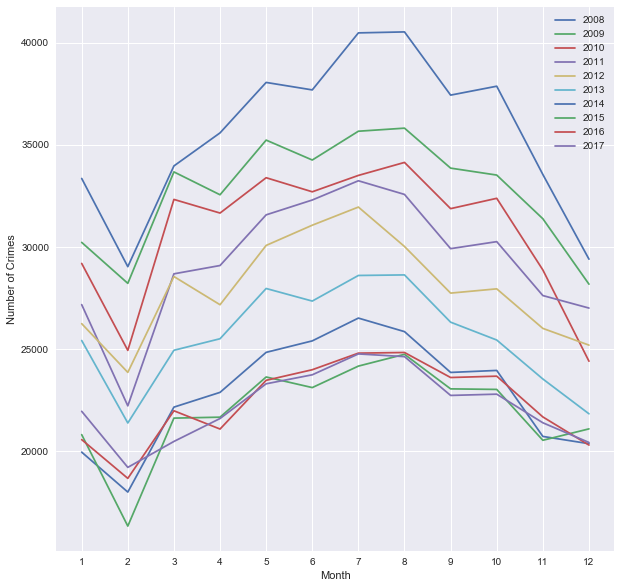

In [85]:
# the drop in 2018 is due to the incomplete data..
plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
for y in crime_monthly_count['Year'].unique().tolist():
    dat = crime_monthly_count[crime_monthly_count['Year']==y]
    ax.plot(dat['Month'], dat['PTYPE2'], label = y)
plt.xticks(crime_monthly_count[crime_monthly_count['Year']==2008]['Month'].unique().tolist())
plt.xlabel('Month')
plt.ylabel("Number of Crimes")
plt.legend()
plt.show()

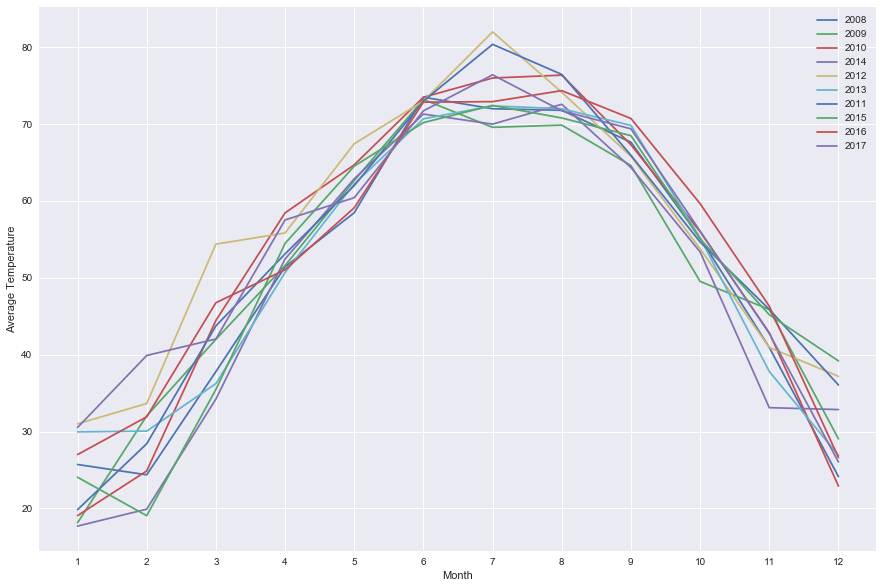

In [86]:
plt.figure()
fig, ax = plt.subplots(figsize=(15,10))
for y in C_count['Year'].unique().tolist():
    dat = C_count[C_count['Year']==y]
    dat = dat[['Year','Month','temp']].drop_duplicates()
    dat = pd.DataFrame(dat.groupby(['Year','Month'])['temp'].mean()) #get the mean temperature for each month
    temps = [x[0] for x in dat.values.tolist()]
    dates = dat.index.levels[1].tolist() #fixing the format of dates
    ax.plot(dates,temps,label=y)
plt.xticks(C_count[C_count['Year']==2008]['Month'].unique().tolist())
plt.xlabel('Month')
plt.ylabel("Average Temperature")
plt.legend()
plt.show()

# Rate of crime per year as a function of temperature

In [87]:
#total number of crimes per day in each month for each year
#i.e for each day, the average daily temperature was X and there were Y number of crimes.
crime_weather = C_count
crime_temperature  = crime_weather.groupby(['Year','Month','Day','temp'])['PTYPE2'].count()
crime_temperature = crime_temperature.reset_index()
#crime_temperature

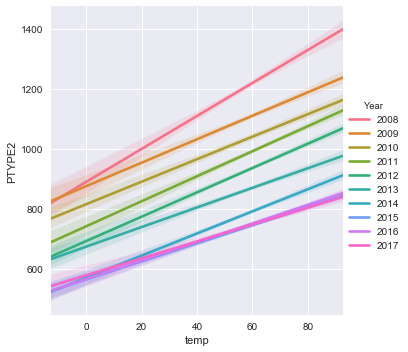

In [88]:
plt.figure(figsize=(15,15))
ax = sns.lmplot(x='temp',y='PTYPE2',hue='Year',data=crime_temperature,scatter=False)

After seeing the base rates of each crime location and type, we will now assume that all crime types (and locations) have the same frequency or, in other words, they are all equal overall. We are interested in detecting how a specific crime type is different across all days of the week or hours of the day.

Is theft or burglary is more likely to occur at a weekday compared to a weekend? Are they more likely to happen in the morning vs evening or late night ? are they more likely to occur in a street vs a bar?

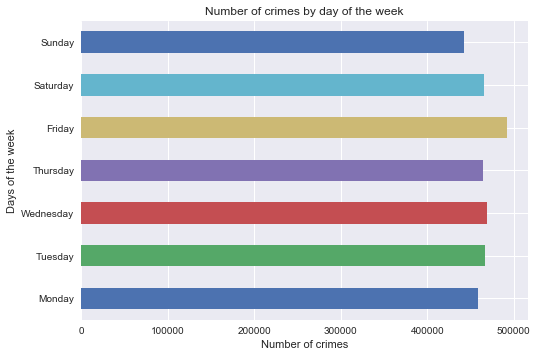

In [89]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

In [90]:
hour_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = crimes.pivot_table(values='ID', index='PTYPE2', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_week     = crimes.pivot_table(values='ID', index=crimes.index.hour, columns=crimes.index.weekday_name, aggfunc=np.size).fillna(0)
hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='ID', index='PTYPE2', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='ID', index='Location Description', columns='PTYPE2', aggfunc=np.size).fillna(0)

In [91]:
hour_by_type.head(5)

Date,1,2,3,4,5,6,7,8,9,10,11,12
PTYPE2,,,,,,,,,,,,
ARSON,508,500,484,466,391,342,320,274,357,378,415,491
CRIMINAL DAMAGE,33404,32887,32602,30550,30734,34189,37688,41534,43632,44240,38215,46466
MURDER,53269,53577,53108,44359,39085,38996,41914,47664,51215,54240,54767,53848
NARCOTICS,35475,31857,28340,24021,20702,28080,39190,43694,54428,49816,48248,65575
NONVIOLENT,4251,4014,4093,3206,2943,3897,5027,5133,5059,5362,5243,4998


Here I used wrapper functions to make some minimal preprocessing and make the heatmap visualization. A trick I used to make heatmaps nicer looking is to use a clustering algorithm to sort the rows into meaningful groups and use group labels to re-sort our matrix.

In [92]:


def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

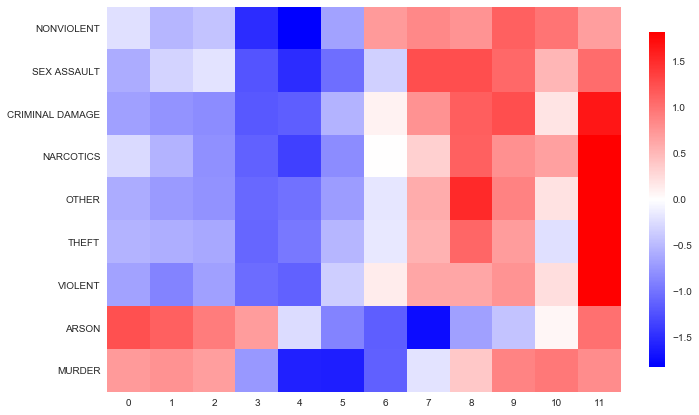

In [93]:
plt.figure(figsize=(10,12))
scale_and_plot(hour_by_type)

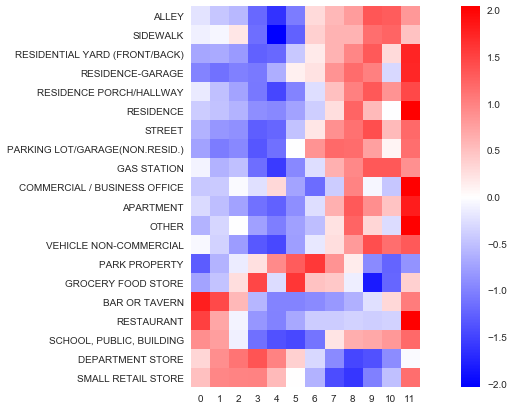

In [94]:
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)

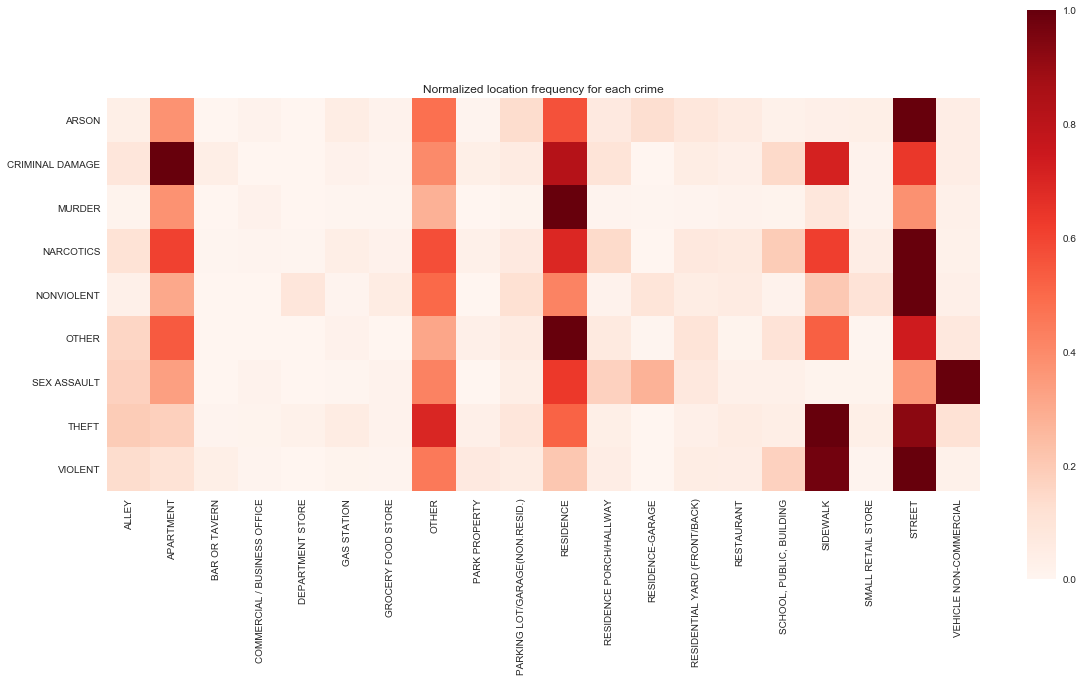

In [95]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()